# Storm Impact Indicator - Explanatory notebook 


## Methodology

The scope of this notebook is to quantify the erosive impact of storms on the beaches. In order to do so we will try to unravel correlations between hydodynamic (Energy of the waves) and morphological data (Erroded volumes of sand along the coastline). 

In order to get revealing conclusions, the important part is to study the Energy/Erosion relation only when waves are reaching a particular threshold on the beach, dimed critical for triggering erosion. Dune foot is normally considered an appropriate threshold (Sallenger,2000)but in this study we will use Highest Astronomical Tide Level as it is much easier to assess.



### Additional filters

As the processes are complex and broad results have a lot of noise, we incoporated the following filters on the data : 

    - Filter only the storms that have an erosion impact, not those that brings back sediment.
    
    - Filter the data, only when threshold is reached in 'storm conditions', hence excluding results caused only by high      tides.
    
    - Filtering the results according to the state of the beach prior to the storm (already erroded or not).
    

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import scipy.io
import time
import calendar
from datetime import datetime
import urllib
from sklearn.model_selection import train_test_split


## Hydrographic & Morphological  Data

### Hydrographic
Data are initially .nc files, one per month and per variables (wave heith :Hs, wave period: Tp, and setup). In order not to overload the CPU with excessive loading time through  'urllib.request.urlretrieve', we created a .csv file for the following coordinates.
- Latitude  : 44.6525
- Longitude : -1.45

For wave heith and period:
Data are given by the model Wave Watch III forced by GFS model for winds

For water level ( Setup):
Data are given by the model MARS2D.

For both dataset, timelapse between two data is 3 hours, and are extracted  at a point located  12 km offshore the beach where morphological profiles were undertaken.

Time is given in seconds since Python epoch (01/01/1970).

### Morphological

Beach profiles are made once per 2 weeks, averaged from 750m  to 1500m of coastline. Precision is of 10cm and they are referenced with respect to Mean Sea Level. Data extend from 2005 to 2015

In [2]:
#Constantes
g=9.8
densi=1025

#==================loading variables================
#import hydro
DF=pd.read_csv('https://raw.githubusercontent.com/env-models/Beach_erosion/master/datasets/Data_frame.csv',delimiter=';')

Hs=DF['hs']
Time_Hs=DF['# time']
Tp=DF['tp']
setup=DF['setup']
print('first date : ',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Hs[0])))
print('last date  : ' ,time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Hs.iloc[-1])))
#import morpho
local_filename, headers = urllib.request.urlretrieve(r'https://raw.githubusercontent.com/env-models/Beach_erosion/master/datasets/TrucVert_OCA.mat')
Prof = scipy.io.loadmat(local_filename)
x=Prof['x']
x=x[0,:]
z =Prof['z']


first date :  2008-01-01 00:00:00
last date  :  2014-12-31 21:00:00


Profil time has to be changed so that it matches hydrological time.

In [3]:
#matching hydro and morpho times
Time_Profil=Prof['date'] #Jours depuis l'an 0
Time_Profil=Time_Profil[0,:]
epoch_matlab= time.strptime("0001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S")#minimum year is 1
epoch_sec=calendar.timegm(epoch_matlab)#secondesde 0 à 1970
var=[X*86400+epoch_sec-365.242*86400-155491 for X in Time_Profil] #adding 1 year here
#var=[X*86400+epoch_sec for X in Time_Profil] 
Time_Profil=var
print('first Profil : ',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[0])))
print('last Profil  : ' ,time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[-1])))

#option to read time:
readable_Time=[]
for i in range(len(Time_Profil)):
    var=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[i]))
    readable_Time=np.append(readable_Time,x)
def read_t(x):
    z=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))
    return z
   
#filter hs according to Time_profil
ini=np.searchsorted(Time_Profil,Time_Hs[0])-1
fin=np.searchsorted(Time_Profil,max(Time_Hs))-1
k=range(ini,fin+1)

first Profil :  2005-04-08 13:00:00
last Profil  :  2015-06-18 13:00:00


The mean profil of the beach from 2005 to 2015 has a significant importance as it allows us to assess the state of the beach prior to a storm.i.e is it erroded or not.

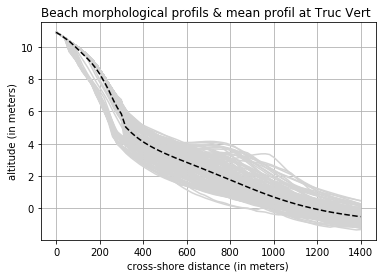

In [4]:

#Mean Profil: 
Zmoy=[]
for j in range(len(x)):
    Zmoy=np.append(Zmoy,np.mean(z[k,j]))
      
end=min(np.argwhere(np.isnan(Zmoy)))-1
end=int(end)
Int_moy=np.trapz(Zmoy[0:end],x[0:end])

#info plot
for i in range(0,len(Time_Profil)):
    plt.plot(z[i,0:end],'lightgray')
plt.plot(Zmoy,'k--')
plt.xlabel('cross-shore distance (in meters)')
plt.ylabel('altitude (in meters)')
plt.title('Beach morphological profils & mean profil at Truc Vert ')
plt.grid()
plt.show()

## Computing the indicator
Once  data is loaded and the various times converted, we can iterate over the full period in order to get the value of the runup for every dates in time.
The information about the runup allows us to assess the maximum extension of the water along the coastline, hence evaluating if a morphological threshold (noted as `beta` in the script) is reached or not. This threeshold is then used as an indicator of whether or not we are in erosive conditions. The wave runup is calculated using the equations given by Stockdown & al., 2006

The indicator itself `SCWmS`, represents the horizontal distance between the dynamic water level (setup + runup) and the morphological setup.
if SCWmS>0: the threeshold is not reached
if SCWmS<0: the threeshold is reached

In [5]:

#%%=======M A I N   L O O P=======================
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx 


penteS =  [] # Slope
borneinf=[]  # lower point on the beach used to calculate the slope
bornesup=[]  # Upper point on the beach used to calculate the slope
runup=[]     # Wave runup
SCWmS=[]     # Indicator
HoS=[]       # Significativ wave heigh at infinite depth
KsS=[]       # Shoaling Coefficient
Lo_inf=[]    #Swell wavelength at infinite depth

beta = 3 #2.14

for n in range(len(Hs)):

    ind=np.searchsorted(Time_Profil,Time_Hs[n],'left')-1    
    ELE=z[ind,:]
    ELE=ELE[~pd.isnull(ELE)]#Nan off
    DIST=x
    Xf=DIST[find_nearest(ELE,beta)]

    #  Slope calculation
    if (setup[n])< min(ELE):  # no indicator when water does not reach low part of the profile 
        penteS = np.append(penteS,np.nan)               
    else:
        borneinf = DIST[find_nearest(ELE,setup[n])]
        bornesup = DIST[find_nearest(ELE,4)]
        penteS = np.append(penteS,abs((4-setup[n])/(borneinf-bornesup)))
                
    #  Shoaling coefficient
    Lo_inf=np.append(Lo_inf,(g*Tp[n]**2)/(2*math.pi))
    tempS=2*math.pi*50/Lo_inf[n]
    KsS=np.append(KsS,math.sqrt(1/(math.tanh(tempS)*(1+2*tempS/math.sinh(2*tempS)))))    
    HoS=np.append(HoS,Hs[n]/KsS[n])
    
    #  Final Setup:
    IrrS=penteS[n]/math.sqrt(HoS[n]/Lo_inf[n])
    if pd.isnull(IrrS):
        runup=np.append(runup,np.nan)        
    elif IrrS<0.3:
        runup=np.append(runup,0.043*math.sqrt(HoS[n]*Lo_inf[n]))        
    elif IrrS >=0.3:
        runup=np.append(runup,1.1*(0.35*penteS[n]*math.sqrt(HoS[n]*Lo_inf[n])+0.5*(math.sqrt(HoS[n]*Lo_inf[n]*(0.563*(penteS[n]**2)+0.004)))))

   #  modele-tide+runup 
    waterlvlmomS=setup[n]+runup[n]
    
   #  Indicator
    if np.isnan(waterlvlmomS):
        SCWmS=np.append(SCWmS,np.nan)
    else:
        indicewlmon=DIST[find_nearest(ELE,waterlvlmomS)]
        SCWmS=np.append(SCWmS,indicewlmon-Xf)       
        
#================M A I N   L O O P - end===================


[]

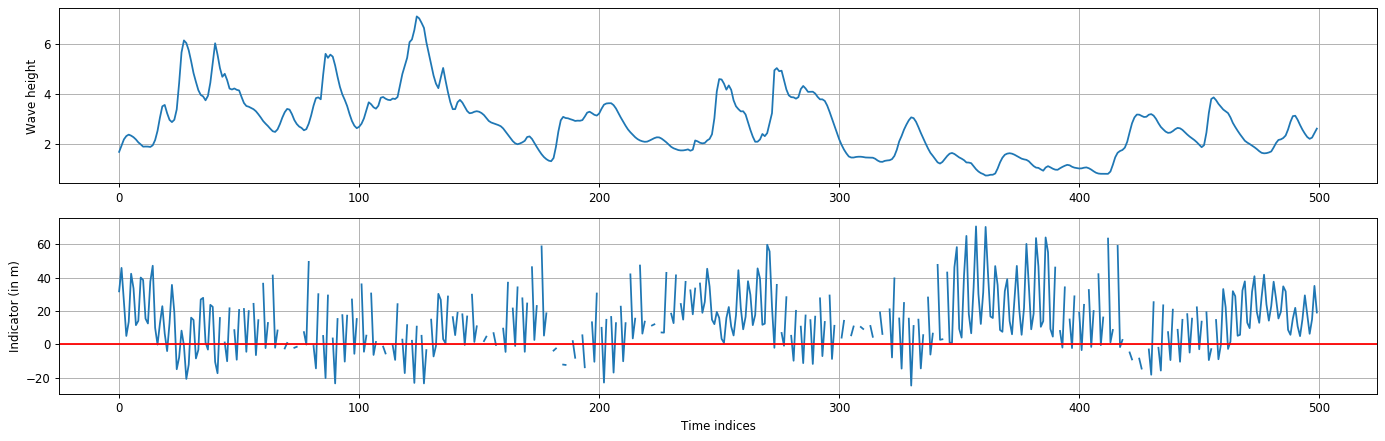

In [8]:
#=====plot-test indicator      
i=0
j=i+500
figure(num=None, figsize=(20, 6), dpi=85, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots(nrows=2, ncols=1)

plt.subplot(2,1,1)
plt.ylabel('Wave height')
plt.plot(Hs[i:j])
plt.grid()

plt.subplot(2,1,2)
plt.xlabel('Time indices')
plt.ylabel('Indicator (in m)')
plt.plot(SCWmS[i:j])
plt.axhline(y=0,color='red')
plt.grid()
plt.plot()

The graph above clearly shows the depency of the indicator in regards to both wave height and tide. Threshold is reached most of the times when waves are above 4m. Nevertheless it can be reached with a quiet sea but a strong  high tide (like in this example at Time indices around 400).
Note that the indicator is not continuous for it is not defined when the water does not reach the lowest part of the profiles

## Storm selection. 

Based on the bibliography, we are using 2 hydrological threesholds to define storm conditions (Splinter et al., 2014, Masselink et al., 2014): 
- The 95% quantile as the storm threshold definition
- the 75% quantile  as the threeshold to define the begining and the ending of the storm.

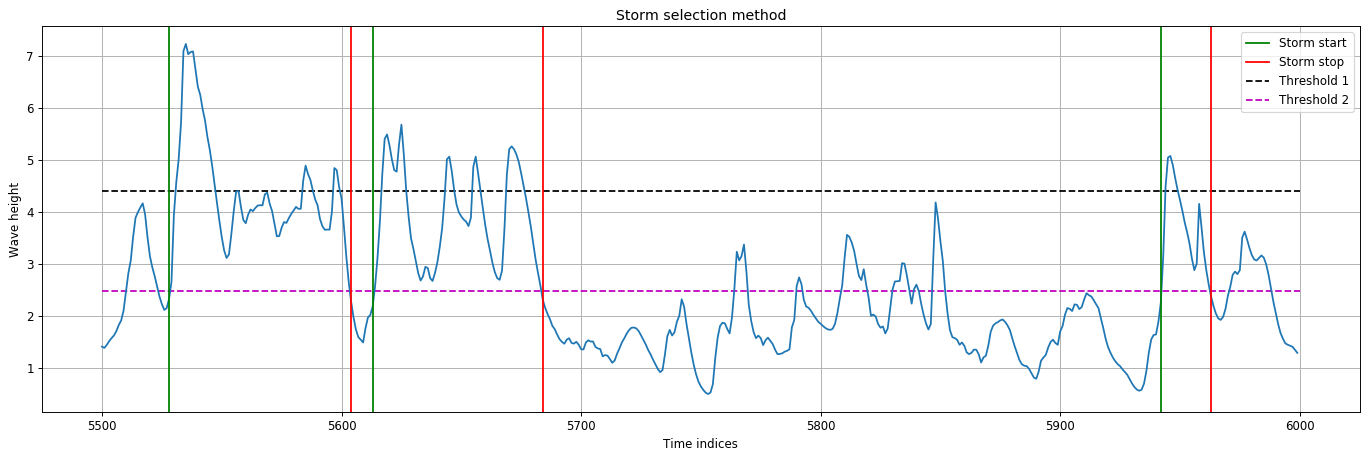

In [10]:

#%%==========Storm selection thresholds=================================
seuil1=np.quantile(Hs,.95)      #Threshold for storm definition
seuil2=np.quantile(Hs,.75);     #Threshold for beginning and ending of the storm

#=================find start and stop of the storm===================
start=[] #indexes for storm starts
stop=[] # indexes for storm endings
ind_last_storm=max([index for index,value in enumerate(Hs) if value < seuil2])
ind_storm = [i for i in range(ind_last_storm) if Hs[i] > seuil1]

for i in ind_storm:
    xxx=[index for index,value in enumerate(Hs[0:i]) if value < seuil2] 
    yyy=[index for index,value in enumerate(Hs[i:-1]) if value < seuil2]
    if xxx:
        start.append(max(xxx))
        stop.append(min(yyy)+i)      
start=sorted(list(set(start)))
stop=sorted(list(set(stop)))

# ======================plot test - storm=================================
i=5500
j=i+500
figure(num=None, figsize=(20, 6), dpi=85, facecolor='w', edgecolor='k')
plt.plot(range(i,j),Hs[i:j])
plt.hlines(seuil1,  i,j, colors='k', linestyles='--',label ='Threshold 1')
plt.hlines(seuil2,  i,j, colors='m', linestyles='--',label ='Threshold 2')
 
for xc in start:
    if xc>i and xc<j:
        plt.axvline(x=xc,color='green',label ='Storm start')
for xc in stop:
        if xc>i and xc<j:
             plt.axvline(x=xc,color='red',label ='Storm stop')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper right')
plt.ylabel('Wave height')
plt.xlabel('Time indices')
plt.title ('Storm selection method')
plt.grid()
plt.show()


# Training and testing the indicator

Now we define train and test populations using the ratio 85/15.
Then we assess the erroded volume between 2 profils in m3/m (>0 if actually erroded) and the energy released upon the beach, in MJ/m

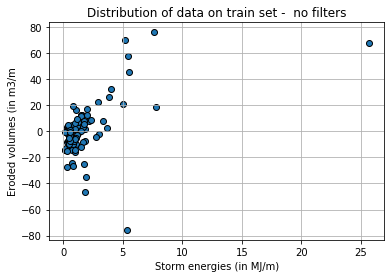

In [12]:

#%%================================== S P L I T ================================
Hs_train, Hs_test=train_test_split(Hs,test_size=0.15, shuffle=False)
Time_train, Time_test=train_test_split(Time_Hs,test_size=0.15, shuffle=False)

#%%==================================T R A I N ========================
#-------------------BLANK TRY------------
Int=[]
V_err=[]
En_sum=[]
En=np.zeros(len(Hs_train))
Hs0=np.zeros(len(Hs_train))

En=(1/16*densi*g*(Hs_train**2))*3

"""Energies"""
ini=np.searchsorted(Time_Profil,min(Time_train))
fin=np.searchsorted(Time_Profil,max(Time_train))-1 
for i in range(ini,fin-1):
    ti=np.searchsorted(Time_train,Time_Profil[i])
    tf=np.searchsorted(Time_train,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
En_sum=En_sum/1000000 # from J to MJ


"""Volumes"""
for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end],x[0:end]))
for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])   


plt.scatter(En_sum,V_err,edgecolors='k')
plt.xlabel('Storm energies (in MJ/m)')
plt.ylabel('Eroded volumes (in m3/m')
plt.title('Distribution of data on train set -  no filters')
plt.grid()

r=np.polyfit(En_sum,V_err,1)
r2=np.polyfit(En_sum,V_err,2)
i=V_err
j=En_sum*r[0]+r[1]
R=np.corrcoef(i,j)[1,0]
#RMSE
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(i, j))

The graph above shows results **without** using the indicator. It is just the natural evolution of the erosion when all of the waves are considered. 

Using the indicator, storm conditions, and capping zero values give the following results 


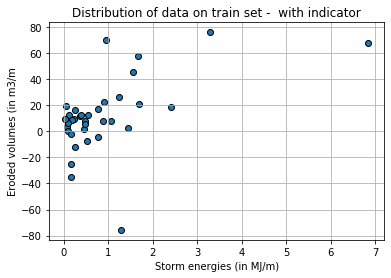

In [14]:
#-----------------including Filters-------------------------
Int=[]
V_err=[]
En_sum=[]
En=np.zeros(len(Hs_train))
Hs0=np.zeros(len(Hs_train))
#FILTER storm conditions
for i in range(0,len(start)):
        if stop[i]<len(Hs_train):#stop give the index of the end of storms (according to Hs array)
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]


#FILTER when indicator is reached
ind = [i for i in range(len(Hs_train)) if SCWmS[i]<0] 
En[ind]=(1/16*densi*g*(Hs0[ind]**2))*3

"""Energies"""
ini=np.searchsorted(Time_Profil,min(Time_train))
fin=np.searchsorted(Time_Profil,max(Time_train))-1 
for i in range(ini,fin-1):
    ti=np.searchsorted(Time_train,Time_Profil[i])
    tf=np.searchsorted(Time_train,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
En_sum=En_sum/1000000 # from J to MJ


"""Volumes"""
for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end],x[0:end]))
for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])   

#FILTERS
#when Energy=0        
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind,axis=0)

plt.scatter(En_sum,V_err,edgecolors='k')
plt.xlabel('Storm energies (in MJ/m)')
plt.ylabel('Eroded volumes (in m3/m')
plt.title('Distribution of data on train set -  with indicator')
plt.grid()


Lets first note that the x axis shrinked, which is normal since we only consider the energies of the waves reaching a certain threshold.

Then we can see how the variance is much greater at low energies, with negative volumes showing how the beach can be replenished with sediments, even during storms. 

In order to improve even more our results, lets cap the negative volumes and use the state of the beach prior to the storm.

- Profils holding more sand than the mean profile will be denoted as : **fat beaches**
- Profils holding less sand than the mean profile will be denoted as :  **erroded beaches**

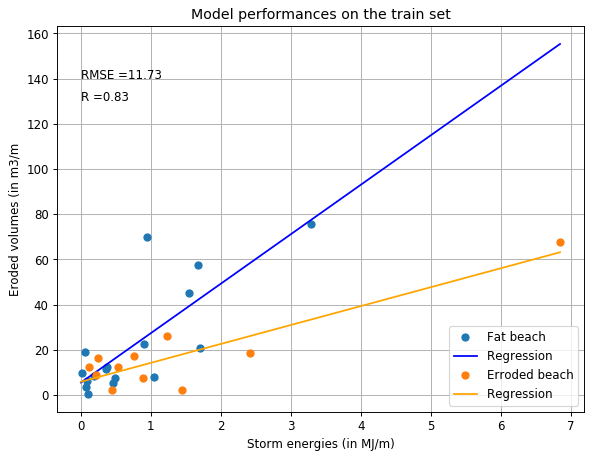

In [15]:

#-----------------including Filters-------------------------
Int=[]
V_err=[]
En_sum=[]
En=np.zeros(len(Hs_train))
Hs0=np.zeros(len(Hs_train))
#FILTER storm conditions
for i in range(0,len(start)):
        if stop[i]<len(Hs_train):#stop give the index of the end of storms (according to Hs array)
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]


#FILTER when indicator is reached
ind = [i for i in range(len(Hs_train)) if SCWmS[i]<0] 
En[ind]=(1/16*densi*g*(Hs0[ind]**2))*3

"""Energies"""
ini=np.searchsorted(Time_Profil,min(Time_train))
fin=np.searchsorted(Time_Profil,max(Time_train))-1 
for i in range(ini,fin-1):
    ti=np.searchsorted(Time_train,Time_Profil[i])
    tf=np.searchsorted(Time_train,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
En_sum=En_sum/1000000 # from J to MJ


"""Volumes"""
for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end],x[0:end]))
for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])   

"""using prestate of the beach"""
Int=Int[0:-1]#cap the last element of Int
Int_min=Int[Int<Int_moy]
Int_sup=Int[Int>Int_moy]

V_err=V_err.reshape(len(V_err),1)
V_err=np.hstack((V_err, np.ones((len(V_err),1))))

V_err[np.where(Int<Int_moy),1]=0
V_err[np.where(Int>Int_moy),1]=1


#==============Volumes- end=========

#FILTERS
#when Energy=0        
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind,axis=0)
#When the beach has not been eroded (Verr <0)
ind2=[i for i in range(0,len(En_sum)) if V_err[i,0] <0]   
En_sum=np.delete(En_sum,ind2)
V_err=np.delete(V_err,ind2,axis=0)

"""pre state of the beach, second part"""
ind_eng=np.where(V_err[:,1]==1)
ind_err=np.where(V_err[:,1]==0)


#=====Statistics===========

r=np.polyfit(En_sum,V_err[:,0],1)
r2=np.polyfit(En_sum,V_err[:,0],2)
#---------------------------engraissé
r_eng=np.polyfit(En_sum[ind_eng],V_err[ind_eng,0].T,1)
r2_eng=np.polyfit(En_sum[ind_eng],V_err[ind_eng,0].T,2)
i=V_err[ind_eng,0]
j=En_sum[ind_eng]*r_eng[0]+r_eng[1]
#R
R_train_eng=np.corrcoef(i,j)[1,0]
#RMSE
from sklearn.metrics import mean_squared_error
rmse_eng = math.sqrt(mean_squared_error(i.T, j))

#-----------------------errodé
r_err=np.polyfit(En_sum[ind_err],V_err[ind_err,0].T,1)
r2_err=np.polyfit(En_sum[ind_err],V_err[ind_err,0].T,2)
i=V_err[ind_err,0]
j=En_sum[ind_err]*r_err[0]+r_err[1]
#R
R_train_err=np.corrcoef(i,j)[1,0]
#RMSE
from sklearn.metrics import mean_squared_error
rmse_err = math.sqrt(mean_squared_error(i.T, j))

#mean
R_train=(R_train_eng*len(En_sum[ind_eng])+R_train_err*len(En_sum[ind_err]))/(len(En_sum))
rmse=(rmse_eng*len(En_sum[ind_eng])+rmse_err*len(En_sum[ind_err]))/(len(En_sum))

#train_set plot
figure(num=None, figsize=(8, 6), dpi=85, facecolor='w', edgecolor='k')
xx=np.linspace(0,max(En_sum),100)
plt.plot(En_sum[ind_eng], V_err[ind_eng,0].T,'o',label='Fat beach')
plt.plot(xx, xx*r_eng[0]+r_eng[1],color='blue',label='Regression ')

plt.plot(En_sum[ind_err], V_err[ind_err,0].T,'o',label='Erroded beach')
plt.plot(xx, xx*r_err[0]+r_err[1],color='orange',label='Regression ')

plt.xlabel('Storm energies (in MJ/m)')
plt.ylabel('Eroded volumes (in m3/m')
plt.title('Model performances on the train set')
plt.grid()
plt.legend(loc='lower right')
plt.text(0,140,'RMSE ='+str(round(rmse,2)),fontsize=10)
plt.text(0,130,'R ='+str(round(R_train,2)),fontsize=10)

plt.show()


As expected, for a given energy, beaches holding more sediment are more likely to be erroded. As indicated by the shape of the regressions, this is particularly the case at higher energies. 
The beach is likely to reach a state of equilibrium where it becomes more resilient.

## Results on the test set 

C:\Users\sound\Documents\Conda\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Text(0.1, 47, 'R =0.97')

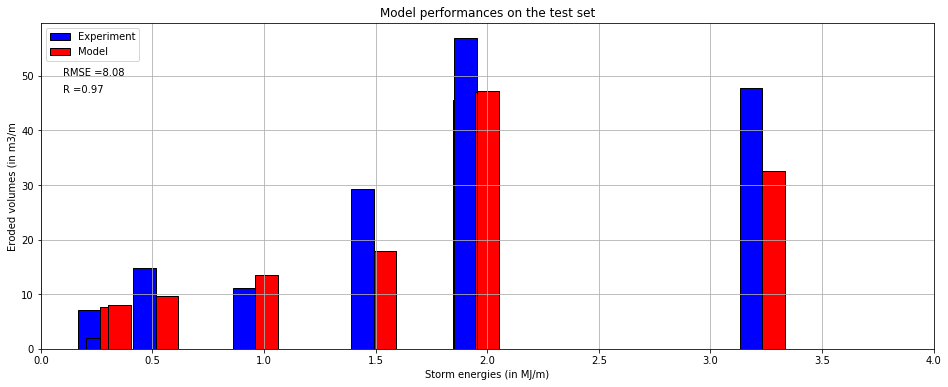

In [17]:

#%%================================== T E S T ========================
Int=[]
V_err=[]
Hs0=np.zeros((len(Hs)))
En=np.zeros((len(Hs)))
En_sum=[]
xi=np.searchsorted(start,len(Hs_train))

#FILTER storm conditions
for i in range(xi,len(start)):
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]

#FILTER when indicator is reached            
ind = [i for i in range(len(Hs_train),len(Hs)) if SCWmS[i]<0]
for i in ind:
    En[ind]=(1/16*densi*g*(Hs0[ind]**2))*3

En=En[len(Hs_train):]#cap tail

#match profil/Energy
ini=np.searchsorted(Time_Profil,min(Time_test))
fin=np.searchsorted(Time_Profil,max(Time_test))-1 # not to run out oh HS
for i in range(ini,fin):
    ti=np.searchsorted(Time_test,Time_Profil[i])
    tf=np.searchsorted(Time_test,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
    
En_sum=En_sum/1000000 #passage de J à MJ

#Volumes
for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end],x[0:end]))

for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])

"""using prestate of the beach"""
#cap the last element of Int
Int=Int[0:-1]
Int_min=Int[Int<Int_moy]
Int_sup=Int[Int>Int_moy]

V_err=V_err.reshape(len(V_err),1)
V_err=np.hstack((V_err, np.ones((len(V_err),1))))

V_err[np.where(Int<Int_moy),1]=0
V_err[np.where(Int>Int_moy),1]=1


#FILTERS
#when Energy=0  
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind,axis=0)

#When the beach has not been eroded (Verr <0)
ind2=[i for i in range(0,len(En_sum)) if V_err[i,0] <0]   
En_sum=np.delete(En_sum,ind2)
V_err=np.delete(V_err,ind2,axis=0)

"""pres state of  the beach - second part"""""
ind_eng=np.where(V_err[:,1]==1)
ind_err=np.where(V_err[:,1]==0)

#=====Statistics=====
#------------------engraissé
i=V_err[ind_eng,0]
j=En_sum[ind_eng]*r_eng[0]+r_eng[1]
#R
R_test_eng=np.corrcoef(i,j)[1,0]

#RMSE
from sklearn.metrics import mean_squared_error
rmse_eng = math.sqrt(mean_squared_error(i.T, j))

#-----------------------errodé
i=V_err[ind_err,0]
j=En_sum[ind_err]*r_err[0]+r_err[1]
#R
R_test_err=np.corrcoef(i,j)[1,0]
#RMSE
from sklearn.metrics import mean_squared_error
rmse_err = math.sqrt(mean_squared_error(i.T, j))

#mean
rmse=(rmse_eng*len(En_sum[ind_eng])+rmse_err*len(En_sum[ind_err]))/(len(En_sum))
R_test=(R_test_eng*len(En_sum[ind_eng])+R_test_err*len(En_sum[ind_err]))/(len(En_sum))

#====test_set plot==========
#plt.bar
fig, ax = plt.subplots(1, 1,figsize=(16,6))
ax.set_xlim(0, 4)
ax.bar(En_sum[ind_eng],V_err[ind_eng,0].flatten(), width=0.1,color='b',edgecolor='k', label='Experiment')
ax.bar(En_sum[ind_eng]+0.1, En_sum[ind_eng]*r_eng[0]+r_eng[1], width=0.1,color='r',edgecolor='k', label='Model')
ax.bar(En_sum[ind_err],V_err[ind_err,0].flatten(), width=0.1,color='b',edgecolor='k')
ax.bar(En_sum[ind_err]+0.1, En_sum[ind_err]*r_err[0]+r_err[1], width=0.1,color='r',edgecolor='k')

plt.legend(loc='upper left')
plt.xlabel('Storm energies in MJ/m')
plt.ylabel('Erroded volumes in m3')
plt.grid()
plt.xlabel('Storm energies (in MJ/m)')
plt.ylabel('Eroded volumes (in m3/m')
plt.title('Model performances on the test set')

plt.text(0.1,50,'RMSE ='+str(round(rmse,2)),fontsize=10)
plt.text(0.1,47,'R ='+str(round(R_test,2)),fontsize=10)
#======================================================================
#===================================E N D =============================
#======================================================================


# Discussion

There is definitly a correlation between the energy of storms and the erosion processes. Nevertheless, noise is too important, particularly at low level energy. Considering only erosive events(storms with Volume>0) lowered this noise, though it remains too influent.

Various elements should be implemented in order to improve model predictions. 

    - First fitting a more complex function assessing the non linear behaviour of the beach response.
    - Considering storm clusters (storms following each others) may improve results.
    - Considering prior state of beaches as continuous features rather than binary could improve the model
    - Bathymetric data would definitly help as well, underwater morphology playing an important role in nearshore wave behaviour.

### References

Masselink, G., Puleo J. A., (2006). Swash-zone morphodynamics, Continental Shelf Research, 33 :1, 661–680. 

Sallenger, A., H., Jr., (2000). Storm Impact Scale for Barrier Islands. Journal of Coastal Research, 16, (3), p. 890-895.

Splinter, K.D.,Carley,J.T.,Goldshani, A. & Tomlinson, R.(2014). A relationship to describe the cumulative impact of storm clusters on beach erosion. Coastal Engineering, 83,49-55

Stockdon, H.F., Holman, R.A., Howd, P.A., Sallenger, A.H., (2006). Empirical parameterization of setup, swash, and runup. Coast. Eng. 53 (7), 573–588